# Evaluate Model
This notebooks loads a specific model so that you can evaluate it.

In [30]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from models.utils.random_features import mean_field_logits
from tqdm.auto import tqdm

In [15]:
# Loading model
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_sngp/seed1/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model(torch.randn(1, 3, 32, 32))
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(checkpoint['args'])
ood_datasets = build_ood_datasets(checkpoint['args'], ds_info['mean'], ds_info['std'])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, sampler=None)# range(1000))
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=256, sampler=None)# range(1000))

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


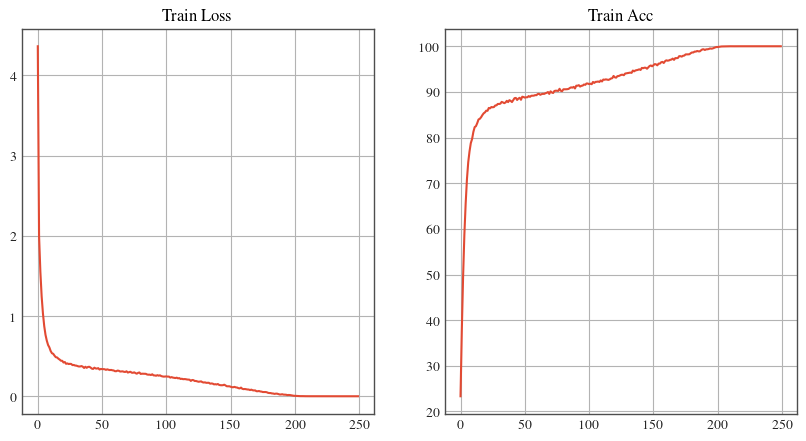

In [16]:
train_history = checkpoint['train_history']
plt.subplot(121)
plt.title('Train Loss')
plt.plot([d['train_loss'] for d in train_history])

plt.subplot(122)
plt.title('Train Acc')
plt.plot([d['train_acc1'] for d in train_history])

In [17]:
# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits.append(model(inp.to(device), mean_field=True).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_ood.append(model(inp.to(device), mean_field=True).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 102/102 [00:19<00:00,  5.36it/s]


In [18]:
# Compute results
entropy_id = ood.entropy_fn(logits.softmax(-1))
entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.CrossEntropyLoss()

results = {
    'ACC': generalization.accuracy(logits, targets)[0].item(),
    'TCE': tce_criterion(logits.softmax(-1), targets).item(),
    'NLL': nll_criterion(logits, targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(results)

{'ACC': 96.18000030517578, 'TCE': 0.020563682541251183, 'NLL': 0.13843823969364166, 'AUROC': 0.8880426321450523}


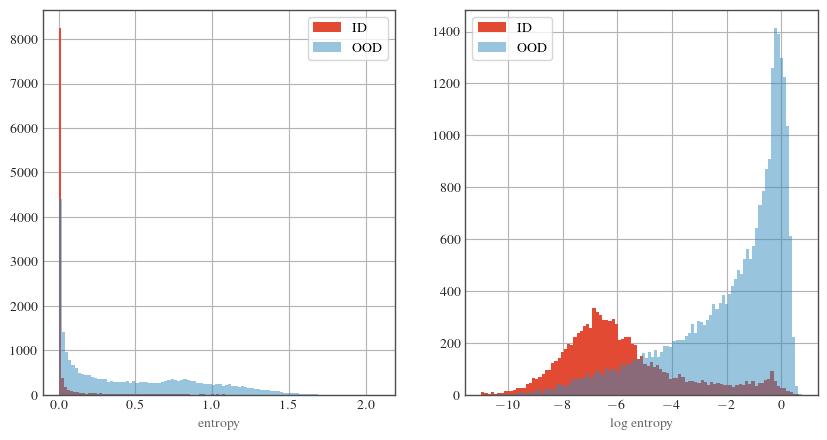

In [20]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

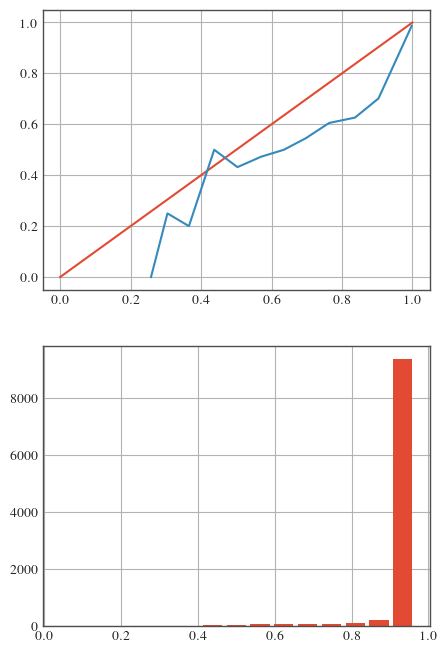

In [21]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)

In [46]:
results = []
mean_field_factors = np.linspace(1, 600, 100)

# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits = {mean_field_factor: [] for mean_field_factor in mean_field_factors}
targets = []

for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        targets.append(tar)
        logits_, cov = model(inp.to(device), return_cov=True)
        for mean_field_factor in mean_field_factors:
            logits_scaled = mean_field_logits(logits_, cov, lmb=mean_field_factor).cpu()
            logits[mean_field_factor].append(logits_scaled)

logits = {mff: torch.cat(l) for mff, l in logits.items()}
targets = torch.cat(targets)

logits_ood = {mean_field_factor: [] for mean_field_factor in mean_field_factors}
for inp, _ in tqdm(ood_loader):
    with torch.no_grad():
        logits_, cov = model(inp.to(device), return_cov=True)
        for mean_field_factor in mean_field_factors:
            logits_scaled = mean_field_logits(logits_, cov, lmb=mean_field_factor).cpu()
            logits_ood[mean_field_factor].append(logits_scaled)
logits_ood = {mff: torch.cat(l) for mff, l in logits_ood.items()}

results = []
for mean_field_factor in mean_field_factors:
    l_id, l_ood = logits[mean_field_factor], logits_ood[mean_field_factor]

    # Compute results
    entropy_id = ood.entropy_fn(l_id.softmax(-1))
    entropy_ood = ood.entropy_fn(l_ood.softmax(-1))
    tce_criterion = calibration.TopLabelCalibrationError()
    nll_criterion = torch.nn.CrossEntropyLoss()

    result_dict = {
        'ACC': generalization.accuracy(l_id, targets)[0].item(),
        'TCE': tce_criterion(l_id.softmax(-1), targets).item(),
        'NLL': nll_criterion(l_id, targets).item(),
        'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
    }
    results.append(result_dict)
    print(result_dict)

100%|██████████| 102/102 [00:19<00:00,  5.16it/s]


{'ACC': 96.18000030517578, 'TCE': 0.020563682541251183, 'NLL': 0.13843823969364166, 'AUROC': 0.8880426321450523}
{'ACC': 96.18000030517578, 'TCE': 0.019306614995002747, 'NLL': 0.13463059067726135, 'AUROC': 0.9033730331899201}
{'ACC': 96.18000030517578, 'TCE': 0.018167680129408836, 'NLL': 0.13156938552856445, 'AUROC': 0.9137001325291949}
{'ACC': 96.18000030517578, 'TCE': 0.01722167804837227, 'NLL': 0.12908275425434113, 'AUROC': 0.9205703614781807}
{'ACC': 96.18000030517578, 'TCE': 0.01589789055287838, 'NLL': 0.12705561518669128, 'AUROC': 0.9253739186385986}
{'ACC': 96.18000030517578, 'TCE': 0.015167499892413616, 'NLL': 0.12540632486343384, 'AUROC': 0.9289085932698218}
{'ACC': 96.18000030517578, 'TCE': 0.014085751958191395, 'NLL': 0.12407446652650833, 'AUROC': 0.9316570317301782}
{'ACC': 96.18000030517578, 'TCE': 0.01264546625316143, 'NLL': 0.12301390618085861, 'AUROC': 0.9338861555009219}
{'ACC': 96.18000030517578, 'TCE': 0.011524807661771774, 'NLL': 0.12218856066465378, 'AUROC': 0.9357

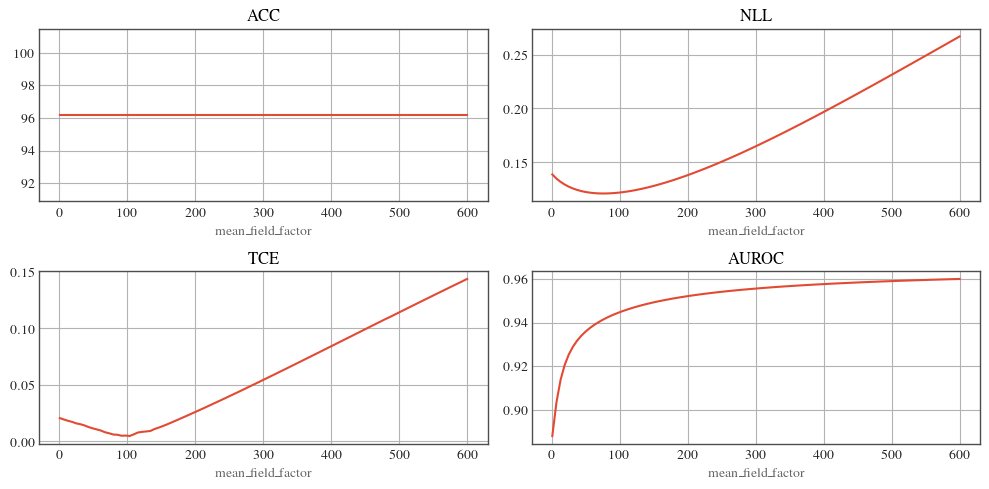

In [47]:
plt.subplot(221)
plt.title('ACC')
plt.plot(mean_field_factors, [d['ACC'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(222)
plt.title('NLL')
plt.plot(mean_field_factors, [d['NLL'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(223)
plt.title('TCE')
plt.plot(mean_field_factors, [d['TCE'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(224)
plt.title('AUROC')
plt.plot(mean_field_factors, [d['AUROC'] for d in results])
plt.xlabel('mean_field_factor')

plt.tight_layout()
plt.show()